# 고급 Keras 전처리 유틸리티 및 레이어를 사용

### 설정

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.7.0


#### 꽃 데이터세트 다운로드

- 클래스 당 하나씩 총 5개의 서브 디렉토리가 있음

    - flowers_photos/ 
         - daisy/ 
         - dandelion/ 
         - roses/ 
         - sunflowers/ 
         - tulips/ 

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


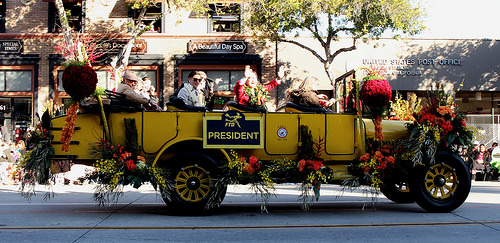

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

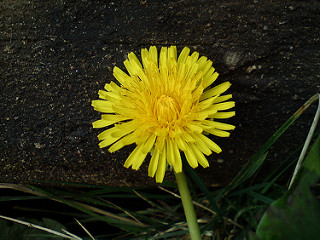

In [5]:
dandelion = list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(dandelion[0]))

---

### tf.keras.preprocessing을 사용하여 로드하기

- `tf.keras.preprocessing.image_dataset_from_directory`를 사용하여 이미지 로드

#### 데이터세트 만들기

- 로더를 위한 매개변수 준비

In [6]:
batch_size = 32    # 데이터세트의 한 행에 포함될 데이터 개수
img_height = 180
img_width = 180

- 훈련용과 검증용 데이터세트 분리

In [7]:
# image_dataset_from_directory은 subset 파라미터로 훈련 세트(training)와 검증 세트(validation)를 구분한다.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Metal device set to: Apple M1


2022-04-07 16:26:56.412966: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-07 16:26:56.413335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


- 클래스 이름 확인

In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [10]:
dataset = train_ds.take(1)
list(dataset.as_numpy_iterator())

2022-04-07 16:26:56.653746: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[(array([[[[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           ...,
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],
  
          [[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           ...,
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02]],
  
          [[2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           [2.55000000e+02, 2.55000000e+02, 2.55000000e+02],
           ...,
           [2.55000000e+02, 2

---

#### 데이터 시각화 하기

- 훈련 세트의 처음 9개의 이미지 출력

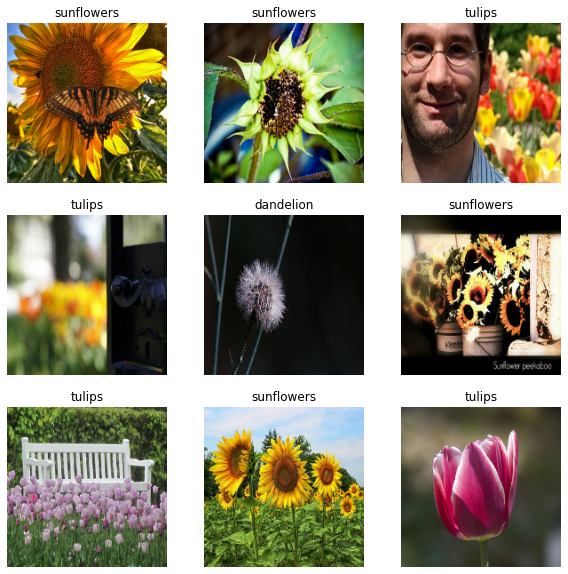

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):    # take(n) : tf.data.Dataset에서 n개의 요소를 가져온다.
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)  # 3 번째 파라미터는 그래프의 index (1부터 시작)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


- 32는 배치 사이즈, 첫 번째 텐서는 이미지, 두 번째 텐서는 클래스, 이미지 텐서는 180X180사이즈의 R,G,B(마지막 요소 3) 컬러 이미지가 배치 사이즈만큼 있다.

---

#### 데이터 표준화 하기

- 컬러 값을 0~1 사이의 값으로 변환
- map을 호출하여 데이터세트에 레이어를 적용

In [13]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99638706


- 모델 정의시 레이어를 포함하여 배포를 단순화 할 수 있음

> 표준화 범위 값을 \[-1, 1\]로 할 수 있으며 Rescaling(1./127.5, offset=-1)로 작성한다.

> 모델에 크기 조정 논리를 포함하기 위해 `tf.keras.layers.experimental.preprocessing.Resizing` 레이어를 대신 사용할 수 있다.

---

#### 성능을 위한 데이터세트 구성하기

- `.cache()` : 
    - 첫 번째 epoch 동안 디스크에서 이미지를 로드하여 메모리에 유지. 
    - 휸련하는 동안 데이터세트의 병목을 방지.
    - 데이터 세트가 너무 커서 한번에 메모리에 로드하지 못하는 경우 사용
- `.prefetch()` :
    - 훈련 중 데이터 전처리와 모델 실행을 병행

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

---

#### 모델 훈련하기

In [16]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [17]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [18]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


2022-04-07 16:26:58.441491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 1.2964 - accuracy: 0.4343

2022-04-07 16:27:07.961463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 11s 97ms/step - loss: 1.2964 - accuracy: 0.4343 - val_loss: 1.1250 - val_accuracy: 0.5572
Epoch 2/3
92/92 [==============================] - 7s 81ms/step - loss: 1.0204 - accuracy: 0.6029 - val_loss: 1.0174 - val_accuracy: 0.5995
Epoch 3/3
92/92 [==============================] - 7s 80ms/step - loss: 0.8696 - accuracy: 0.6740 - val_loss: 0.9559 - val_accuracy: 0.6335


---

### 미세 제어를 위해 tf.data 사용하기

- `tf.keras.preprocessing`는 이미지 디렉토리에서 `tf.data.Dataset`를 편리하게 작성하기 위한 방법
- 보다 세밀한 제어를 위해서는 `tf.data`를 사용하여 자체 파이프라인을 작성해야 함

In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [20]:
for f in list_ds.take(5):
  print(f.numpy())

b'/Users/mazdah/.keras/datasets/flower_photos/dandelion/18215579866_94b1732f24.jpg'
b'/Users/mazdah/.keras/datasets/flower_photos/daisy/5881907044_92a85a05c8_n.jpg'
b'/Users/mazdah/.keras/datasets/flower_photos/roses/4065283966_9504b98269.jpg'
b'/Users/mazdah/.keras/datasets/flower_photos/roses/3450344423_63ba3190e3.jpg'
b'/Users/mazdah/.keras/datasets/flower_photos/dandelion/8723679596_391a724d4f_m.jpg'


- 파일의 트리 구조를 이용하여 class_names 목록을 컴파일

In [21]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


- 훈련 세트와 검증 세트 분할

In [22]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

- 데이터세트 길이 확인

In [23]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


- 파일 경로를 (img, label)로 변환하는 함수 작성

In [24]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [25]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [26]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

- Dataset.map을 사용하여 image, label 쌍의 데이터세트를 작성

In [27]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [28]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


---

#### 성능을 위한 데이터세트 구성

- 잘 섞는다.
- 배치 처리한다.
- 가능한 빨리 배치를 사용할 수 있어야 한다.

In [29]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

---

#### 데이터 시각화하기

2022-04-07 16:31:19.085124: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


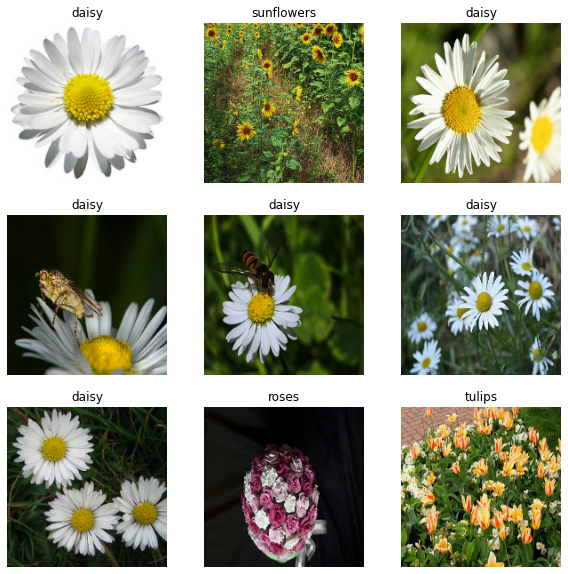

In [30]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

---

#### 모델 계속 훈련하기

In [31]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


2022-04-07 16:34:00.037035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 0.7953 - accuracy: 0.7003

2022-04-07 16:34:07.610648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 9s 87ms/step - loss: 0.7953 - accuracy: 0.7003 - val_loss: 0.7482 - val_accuracy: 0.7275
Epoch 2/3
92/92 [==============================] - 7s 80ms/step - loss: 0.6109 - accuracy: 0.7636 - val_loss: 0.7457 - val_accuracy: 0.7071
Epoch 3/3
92/92 [==============================] - 7s 79ms/step - loss: 0.4278 - accuracy: 0.8532 - val_loss: 0.7864 - val_accuracy: 0.7207


---

### TensorFlow 데이터세트 사용하기

- TensorFlow 데이터세트를 사용하여 꽃 데이터세트를 다운로드

In [32]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

2022-04-07 16:36:08.951961: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tf_flowers-train.tfrecord...:   0%|          | 0/3670 [00:00<?, ? examples/s]

Dataset tf_flowers downloaded and prepared to /Users/mazdah/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [33]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


2022-04-07 16:39:14.976865: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


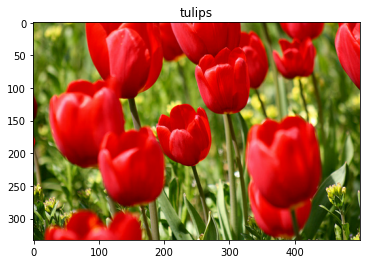

In [34]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [35]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)